In [1]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from gaussian_utils import V_mixture2D, gradV_mixture2D
from mfvi_main import *



## Step 0: define product Gaussian mixture parameters

We provide the means and weights for the product Gaussian mixture model; we assume unit variance for all the components of the mixture. We assume access to $V$ and $\nabla V$ 

In [2]:
d = 2
m11=2.
m12=-2.
m21=2.
m22=-2.

w11=0.25
w12=0.75
w21=0.75
w22=0.25
s=1

m = [m11,m12,m21,m22]
w = [w11,w12,w21,w22]

V = lambda x: V_mixture2D(x,m,w,s)
gradV= lambda x: gradV_mixture2D(x,m,w,s)

## Step 1: Set up our MF-VI algorithm

Define the mesh-size and truncation parameter of interest; these initialize the dictionary that will be used for all components.

In [3]:
mesh=0.2
trunc=2.9

MFVI_obj = MFVI(V, gradV, mesh, trunc,d)

## Step 2: Run the algorithm 

Many parameters for our algorithm have default values, though the $\alpha$ parameter, as well as the step-size (for both $\lambda$ and $v$) are required, as is the initialization of the weights (the translation parameter $v$ is always initialized at the origin).

In [4]:
alpha = 0.1
step_size = 1e-3
step_size_v = step_size
num_iters = 3000
batch_size = 2000
lamb0 = np.zeros((d, MFVI_obj.J))

MFVI_obj.SPGD(alpha, step_size, step_size_v, lamb0, batch_size=batch_size, num_iters=num_iters)


Iter: 50
Iter: 100
Iter: 150
Iter: 200
Iter: 250
Iter: 300
Iter: 350
Iter: 400
Iter: 450
Iter: 500
Iter: 550
Iter: 600
Iter: 650
Iter: 700
Iter: 750
Iter: 800
Iter: 850
Iter: 900
Iter: 950
Iter: 1000
Iter: 1050
Iter: 1100
Iter: 1150
Iter: 1200
Iter: 1250
Iter: 1300
Iter: 1350
Iter: 1400
Iter: 1450
Iter: 1500
Iter: 1550
Iter: 1600
Iter: 1650
Iter: 1700
Iter: 1750
Iter: 1800
Iter: 1850
Iter: 1900
Iter: 1950
Iter: 2000
Iter: 2050
Iter: 2100
Iter: 2150
Iter: 2200
Iter: 2250
Iter: 2300
Iter: 2350
Iter: 2400
Iter: 2450
Iter: 2500
Iter: 2550
Iter: 2600
Iter: 2650
Iter: 2700
Iter: 2750
Iter: 2800
Iter: 2850
Iter: 2900
Iter: 2950


## Step 3: Generate samples from mean-field approximation

In [5]:
N_samples = 50000
mfapprox = MFVI_obj.gen_mfapprox(N_samples)


## Generate samples from ground-truth product mixture

We next generate samples that follow the prescribed mixture distribution. 

In [6]:
# Define parameters for product Gaussian mixture
n_components = 4 
mu1 = [m11, m21]
mu2 = [m11, m22]
mu3 = [m12, m21]
mu4 = [m12, m22]
weights = [w11*w21, w11*w22, w12*w21, w12*w22]
# Generate random samples from each Gaussian
X1 = np.random.multivariate_normal(mu1, np.eye(d), N_samples)
X2 = np.random.multivariate_normal(mu2, np.eye(d), N_samples)
X3 = np.random.multivariate_normal(mu3, np.eye(d), N_samples)
X4 = np.random.multivariate_normal(mu4, np.eye(d), N_samples)
# Concatenate the samples
X = np.vstack([X1, X2, X3, X4])
X_comb = [X1, X2, X3, X4]

choices = np.random.choice(range(0, 4), p=weights, size=N_samples)
ground_truth_samples = np.array([X_comb[choices[i]][i,:] for i in range(N_samples)])


## Visualization

Finally, we visualize the two collections of samples via kernel density estimators (KDEs).

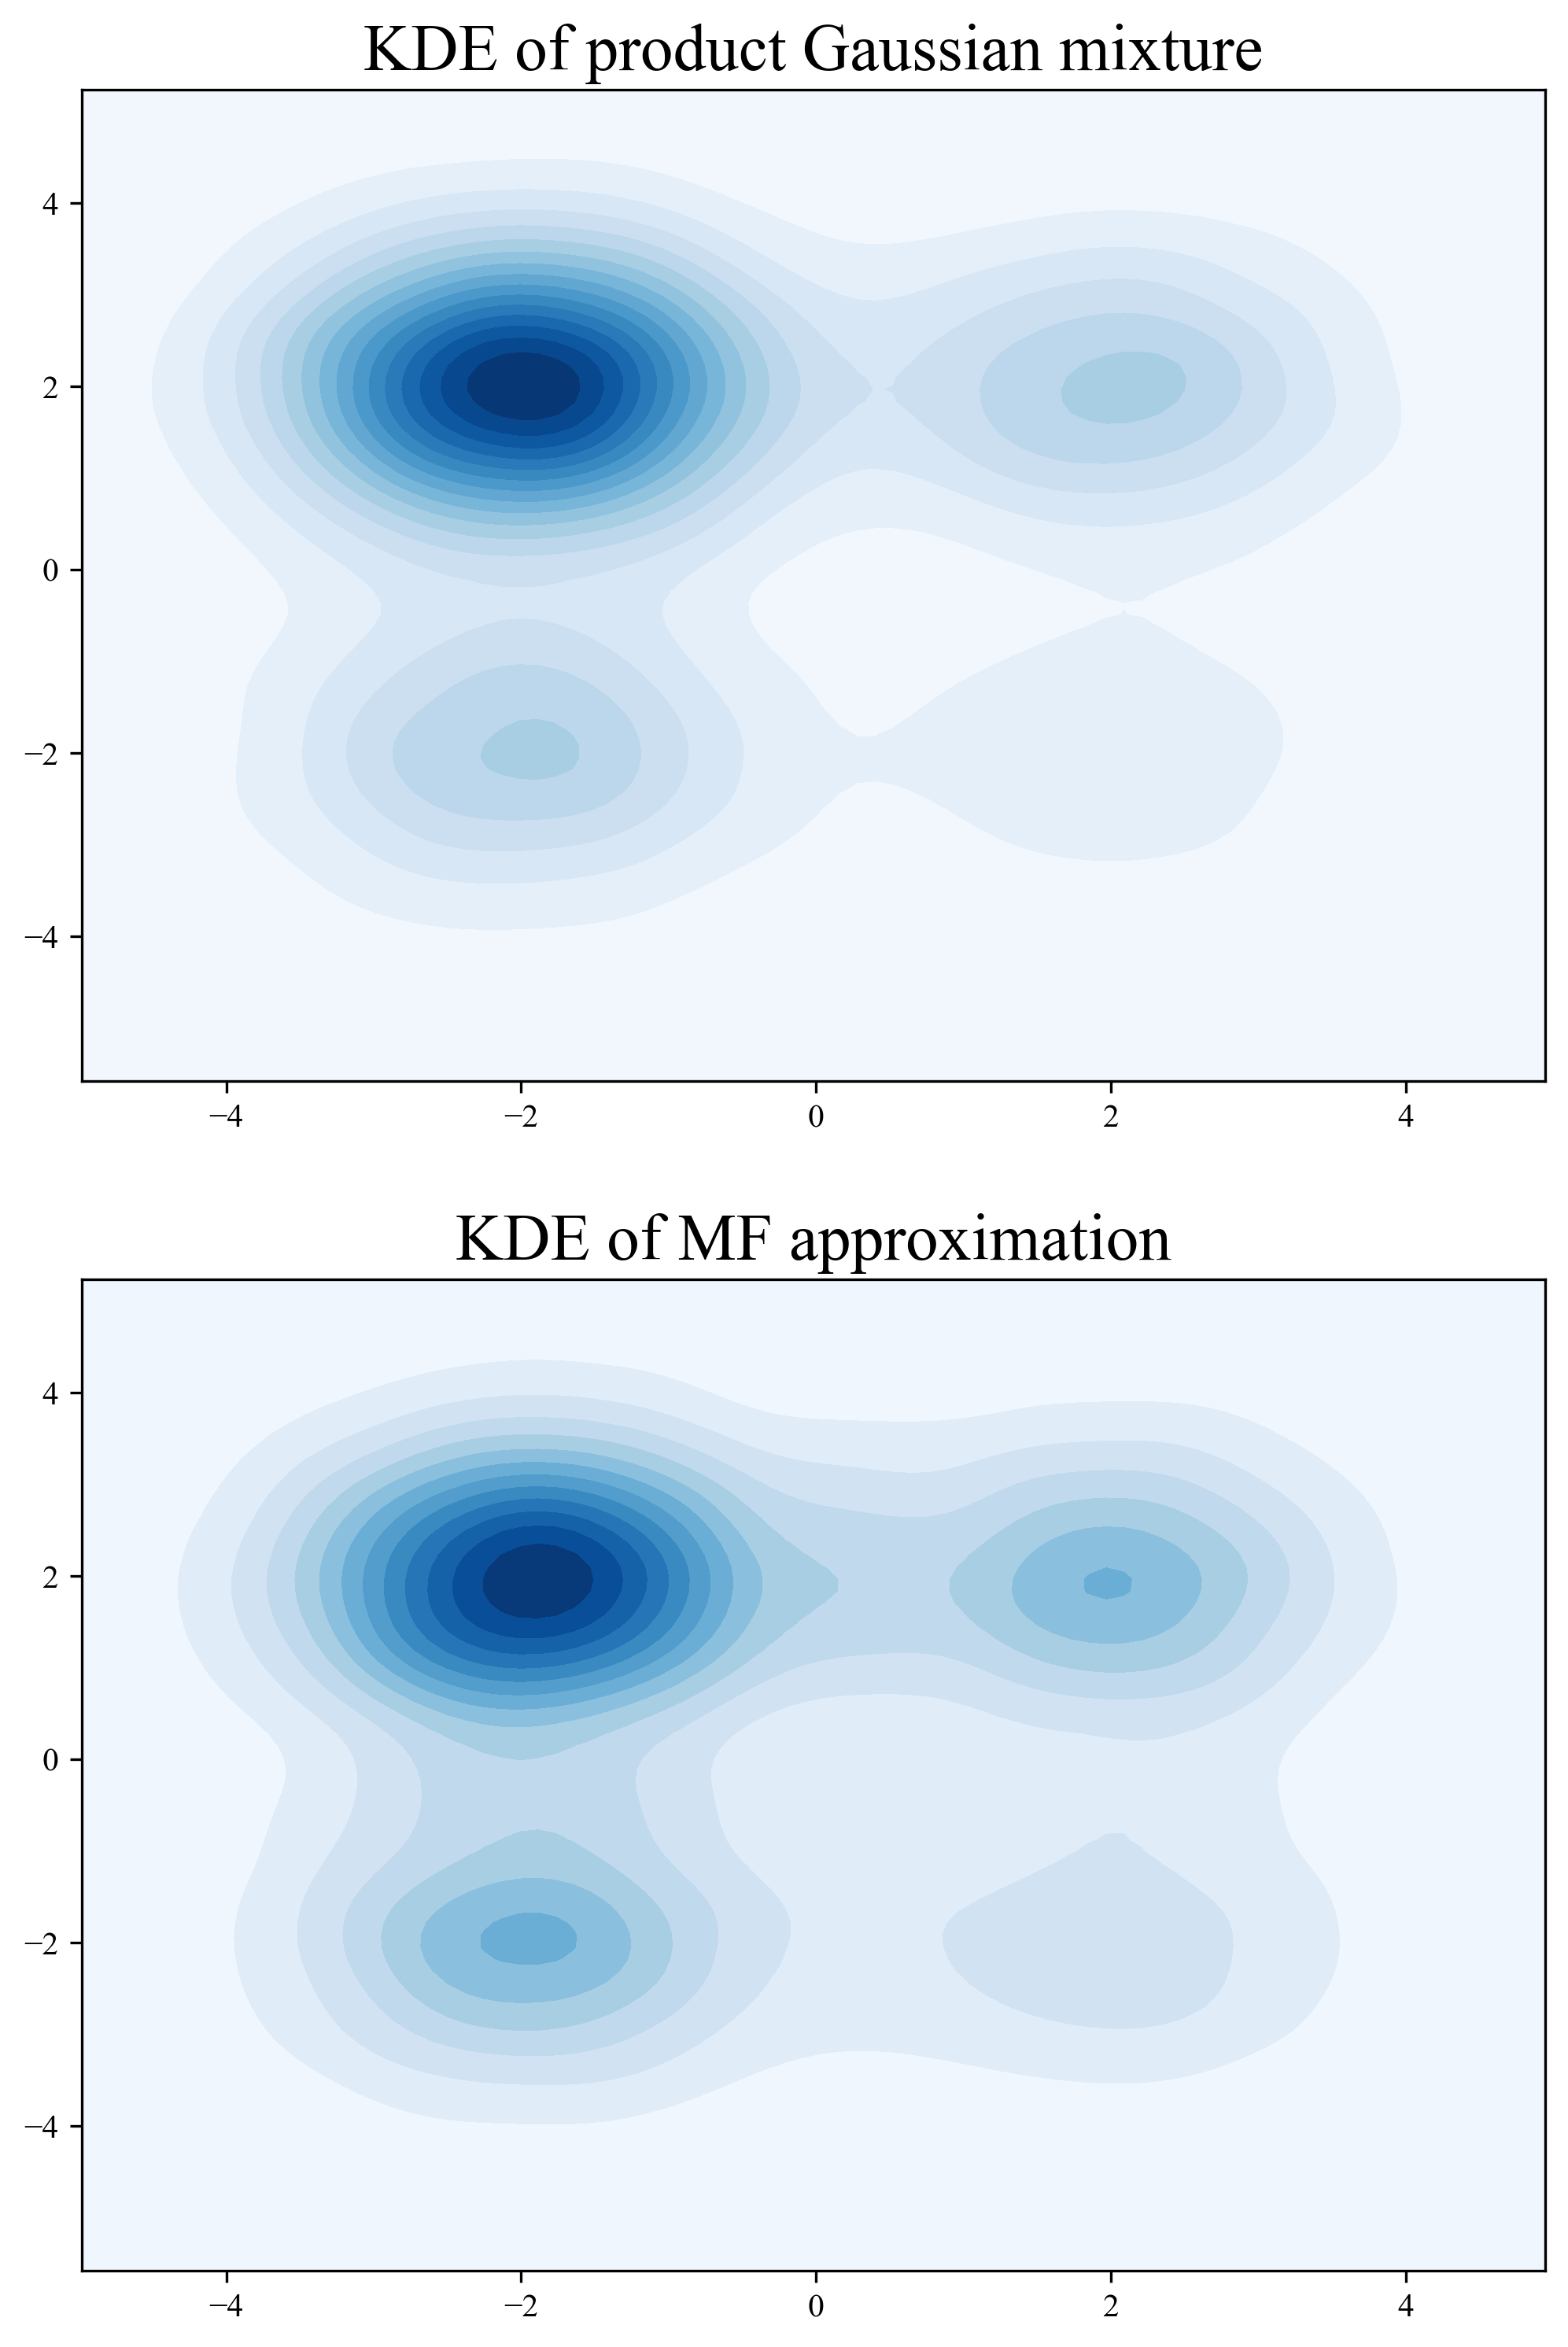

In [7]:
x_min, x_max = ground_truth_samples[:, 0].min() , ground_truth_samples[:, 0].max() 
y_min, y_max = ground_truth_samples[:, 1].min() , ground_truth_samples[:, 1].max() 
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]  # 100j specifies 100 points along each dimension
positions = np.vstack([x.ravel(), y.ravel()])

# KDE of true samples
true_kde = stats.gaussian_kde(ground_truth_samples.T)
z_true = np.reshape(true_kde(positions).T, x.shape)

# KDE of MF samples
kde_mfapprox = stats.gaussian_kde(mfapprox.T)
z_mfapprox = np.reshape(kde_mfapprox(positions).T, x.shape)

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(dpi=300, figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.title('KDE of product Gaussian mixture',fontsize='20')
plt.contourf(x, y, z_true, levels=15, cmap='Blues')
plt.xlim([x_min+1, x_max-1])
plt.ylim([y_min+1, y_max-1])

plt.subplot(2,1,2)
plt.title('KDE of MF approximation',fontsize='20')
plt.contourf(x, y, z_mfapprox, levels=15, cmap='Blues')
plt.xlim([x_min+1, x_max-1])
plt.ylim([y_min+1, y_max-1])
plt.show()
